### Introduction
Model of electric engine. 
1000 - 10000 RPMs.

Differential equation describing the system.

$$J\frac{d\omega}{dt} = M_e - M_0 - M_{LOAD}$$
where:
- $M_e$: electromagnetic moment
- $M_0$: braking moment
- $M_{LOAD}$: load moment
- $I$: moment of inertia

Transformation to differential form using the Eulerian method.
$$I\frac{d\omega(t+\Delta t) - \omega (t)}{\Delta t} = M_e(t)-M_0-M_{LOAD}(t)$$
$$\omega (t+\Delta t) = \omega(t) + \frac{\Delta t}{I}(M_e(t)- M_0-M_{LOAD}(t))$$

What about $M_e(t)$?
$$U_{PI}(t) = Kp \cdot e(t) + Ki \sum^t_{k=0}e(k)\Delta t$$
$$M_e(t) = U_{PI} * const$$
$$e(t) = \omega_{ref} - \omega(t)$$

### Defined Parameters

In [632]:
# Parameters of simulation
referencedRevolutionsPerMinute = 3000

# Simulation time parameters
timeOfSimulation = 1000
timeOfSample = 0.04

# Parameters of crankshaft
brakingMoment = 0.2
loadMoment = 10
momentOfInertia = 1.2
constantOfElectromagneticMoment = 0.8 #! dostosowac

# Parameters of PI regulator
Kp = 0.005
Ki = 0.0002
Kd = 0.001

# Constraints
Umax = 24
Umin = 0


# Lists of measured values
# TODO: Think about initalizing first elements here in list
timeOfSimulationList = [0.0]
loadMomentList = [0.0] 
electromagneticMomentList = [0.0]
adjustmentErrors = [referencedRevolutionsPerMinute]
voltagesList = [0.0]
revolutionsList = [1000]

### Calculations

In [633]:
def calculateNumberOfIterations(timeOfSimulation: int, timeOfSample: float) -> int:
    """ This function calculates number of iterations for simulation of process

        @Parameters:
        - timeOfSimulation (int): total time of simulation in seconds
        - timeOfSample (float): time at which we repeat the measurement in seconds

        @Return:
        - int: number of iterations
    """
    return int(timeOfSimulation / timeOfSample) + 1

In [634]:
def calculateAdjustmentError(referencedRevolutionsPerMinute: float, currentRevolutionsPerMinute: float) -> float:
    # TODO Floats or Integers???
    """ This function calculates adjustment error which is difference between referenced value and current one

        @Parameters:
        - referencedRevolutionsPerMinute (float): set value to be obtained by regulator
        - currentRevolutionsPerMinute (float): current value

        @Return:
        - float: error
    """
    return referencedRevolutionsPerMinute - currentRevolutionsPerMinute

In [635]:
def calculateVoltageOfRegulator(errorList: list[float], iteration: int) -> float:
    """
    This function calculates current voltage of regulator using PID control.

    @Parameters:
    - errorList (list[float]): list of errors at the moment and before
    - iteration (int): information about current simulation iteration

    @Return:
    - float: current voltage of regulator
    """
    # Składnik proporcjonalny
    proportional = Kp * errorList[iteration]

    # Składnik całkowy
    integral = Ki * sum(errorList) * timeOfSample

    # Składnik różniczkowy
    if iteration > 0:  # Różniczkowanie możliwe od drugiej iteracji
        derivative = (errorList[iteration] - errorList[iteration - 1]) / timeOfSample
    else:
        derivative = 0.0  # Na pierwszej iteracji brak różniczkowego wkładu

    derivative_term = Kd * derivative

    # Suma wkładów regulatora
    voltage = proportional + integral + derivative_term


    return voltage


In [636]:
def calculateElectromagneticMoment(constant : float, currentVoltage : float) -> float:
    """ This function calculates current electromagnetic moment based on voltage of regulator

        @Parameters:
        - constant (float): used to scale moment 
        - currentVoltageOfRegulator (float): voltage of regulator at the moment

        @Return
        - float: current electromagnetic moment
    """
    return constant * currentVoltage

In [637]:
def calculateNormalizedVoltage(voltgeOfRegulator : float) -> float:
    """ This function calculates normalized voltage based on predefined constraints <0;24> [V]

    @Parameters:
    - voltageOfRegulator (float): current voltage of regulator

    @Returns:
    - float: normalized voltage used to create electromagnetic moment
    """
    return max(Umin, min(Umax, voltgeOfRegulator))

In [638]:
def calculateRevoltions(revolutionsList, electromagneticMomentList):
    omega = revolutionsList[-1] *(2*3.14/60)
    acceleration = (
        electromagneticMomentList[-1] - loadMoment - brakingMoment) / momentOfInertia
    new_omega=omega+timeOfSample*acceleration

    return new_omega * (60 / (2 * 3.14))

### Simulation

In [639]:
for i in range(calculateNumberOfIterations(timeOfSimulation, timeOfSample)):
    # Update simulation time
    timeOfSimulationList.append(timeOfSimulationList[-1] + timeOfSample)


    # Calculate normalized voltage
    voltage = calculateNormalizedVoltage(
        calculateVoltageOfRegulator(adjustmentErrors, -1))
    print(calculateVoltageOfRegulator(adjustmentErrors, -1))
    voltagesList.append(voltage)

    # Calculate electromagnetic moment
    electromagneticMoment = calculateElectromagneticMoment(
        constantOfElectromagneticMoment, voltagesList[-1])
    electromagneticMomentList.append(electromagneticMoment)

    # Calculate revolutions and update revolutions list
    revolutions = calculateRevoltions(
        revolutionsList, electromagneticMomentList)
    revolutionsList.append(revolutions)
    #print(f"Step {i}: Referenced RPM = {referencedRevolutionsPerMinute}, Current RPM = {revolutionsList[-1]}, Current Moment = {electromagneticMomentList[-1]}")

        # Calculate adjustment error
    adjustmentError = calculateAdjustmentError(
        referencedRevolutionsPerMinute, revolutionsList[-1])
    adjustmentErrors.append(adjustmentError)
    

15.024
10.037098549808917
10.05655536979938
10.07599289385534
10.095411106939727
10.11480999407398
10.134189540338008
10.153549730870155
10.17289055086714
10.192211985584024
10.211514020334166
10.230796640489169
10.250059831478849
10.269303578791178
10.288527867972249
10.307732684626224
10.326918014415295
10.346083843059638
10.365230156337363
10.38435694008448
10.403464180194845
10.422551862620118
10.441619973369711
10.460668498510762
10.47969742416807
10.498706736524056
10.517696421818728
10.536666466349615
10.555616856471744
10.574547578597574
10.59345861919697
10.61234996479714
10.63122160198261
10.650073517395146
10.668905697733747
10.687718129754572
10.706510800270902
10.725283696153095
10.744036804328543
10.76277011178162
10.781483605553634
10.800177272742795
10.818851100504151
10.837505076049556
10.856139186647615
10.874753419623643
10.893347762359605
10.911922202294097
10.930476726922272
10.949011323795812
10.967525980522863
10.986020684768008
11.00449542425221
11.0229501867527

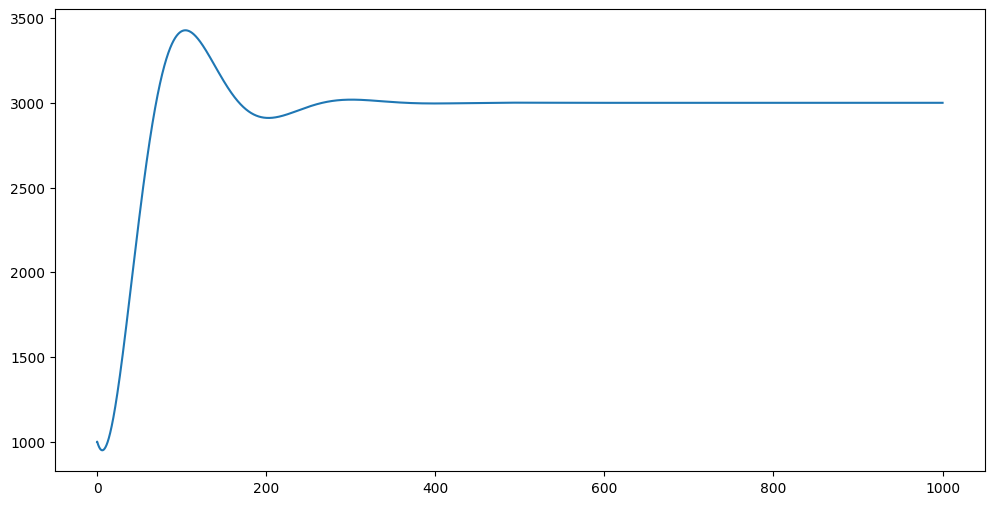

In [640]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(timeOfSimulationList, revolutionsList)

In [641]:
print(voltagesList[:50])
print(electromagneticMomentList[:20])
print(timeOfSample)

[0.0, 15.024, 10.037098549808917, 10.05655536979938, 10.07599289385534, 10.095411106939727, 10.11480999407398, 10.134189540338008, 10.153549730870155, 10.17289055086714, 10.192211985584024, 10.211514020334166, 10.230796640489169, 10.250059831478849, 10.269303578791178, 10.288527867972249, 10.307732684626224, 10.326918014415295, 10.346083843059638, 10.365230156337363, 10.38435694008448, 10.403464180194845, 10.422551862620118, 10.441619973369711, 10.460668498510762, 10.47969742416807, 10.498706736524056, 10.517696421818728, 10.536666466349615, 10.555616856471744, 10.574547578597574, 10.59345861919697, 10.61234996479714, 10.63122160198261, 10.650073517395146, 10.668905697733747, 10.687718129754572, 10.706510800270902, 10.725283696153095, 10.744036804328543, 10.76277011178162, 10.781483605553634, 10.800177272742795, 10.818851100504151, 10.837505076049556, 10.856139186647615, 10.874753419623643, 10.893347762359605, 10.911922202294097, 10.930476726922272]
[0.0, 12.0192, 8.029678839847135, 8.